In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Apple SD Gothic Neo'
matplotlib.rcParams['axes.unicode_minus'] = False

In [63]:
df1 = pd.read_csv('./df1.csv')
df1.columns

Index(['Unnamed: 0', 'EXAMIN_YEAR', 'exmprs_no', 'age', 'sex', 'pha_04z1',
       'pha_05z1', 'pha_06z1', 'pha_07z1', 'pha_08z1', 'pha_09z1', 'phb_01z1',
       'phb_02z1', 'phb_03z1', 'pha_11z1', 'mtc_17z1', 'mtc_18z1', 'mta_01z1',
       'mta_02z1', 'mtb_01z1', 'mtb_02z1', 'mtb_07a1', 'mtb_07b1', 'mtb_07c1',
       'mtb_07d1', 'mtb_07e1', 'mtb_07f1', 'mtb_07g1', 'mtb_07h1', 'mtb_07i1'],
      dtype='object')

In [64]:
# 인코딩할 데이터 프레임 생성
encode = pd.DataFrame()

#SEQ, 나이, 성별
encode['SEQ'] = df1['exmprs_no']
encode['age'] = df1['age']
encode['sex'] = df1['sex']

#PHQ9 점수 계산
#7 응답거부, 9 모름 - np.nan #8 비해당 - 0으로 처리
mapping = {7:np.nan, 8:0, 9:np.nan}

phq_cols = ['mtb_07a1', 'mtb_07b1', 'mtb_07c1', 'mtb_07d1', 'mtb_07e1', 'mtb_07f1', 'mtb_07g1', 'mtb_07h1', 'mtb_07i1']

df1[phq_cols] = df1[phq_cols].replace(mapping)

encode['phq'] = 0

for col in phq_cols:
    encode['phq'] += df1[col]

#수면 시간 평균, 차이
#77 응답거부, 99 모름 - np.nan으로 처리
mapping2 = {77:np.nan, 99:np.nan}
sleep_cols = ['mtc_17z1', 'mtc_18z1']
df1[sleep_cols] = df1[sleep_cols].replace(mapping2)

encode['sleep_mean'] = df1[['mtc_17z1', 'mtc_18z1']].mean(axis=1)
encode['sleep_diff'] = (df1['mtc_17z1'] - df1['mtc_18z1']).abs()

#신체능력
#77 응답거부, 99 모름 - np.nan #88 비해당 - 0으로 처리
mapping3 = {77:np.nan, 88:0, 99:np.nan}
pha_cols = ['pha_04z1', 'pha_05z1', 'pha_06z1', 'pha_07z1', 'pha_08z1', 'pha_09z1', 'phb_01z1', 'phb_02z1', 'phb_03z1']

df1[pha_cols] = df1[pha_cols].replace(mapping3)

#신체능력- 고강도
#하루 평균 몇분으로 통일
# 일주일 중 몇회 * ((하루에 몇시간 * 60) + 하루에 몇분) / 7
encode['ph_hard'] = df1['pha_04z1'] * ((df1['pha_05z1'] * 60) + df1['pha_06z1']) / 7

#신체능력 - 중강도
encode['ph_medium'] = df1['pha_07z1'] * ((df1['pha_08z1'] * 60) + df1['pha_09z1']) / 7

#신체능력 - 걷기
encode['ph_walk'] = df1['phb_01z1'] * ((df1['phb_02z1'] * 60) + df1['phb_03z1']) / 7

#신체능력 - 유연성(스트레칭 포함) - 최근 일주일간 여부(0/1)
mapping ={1:0, 2:1, 3:1, 4:1, 5:1, 6:1}
encode['ph_flex'] = df1['pha_11z1'].replace(mapping)


#일상능력
#스트레스 느끼는 정도(1:거의 x, 2:조금, 3: 많이, 4: 대단히 많이)
mappping_stress = {1:4, 2:3, 3:2, 4:1}
encode['stress'] = df1['mta_01z1']

#일상생활에 지장이 있을정도의 슬픔, 절망감(0:없음, 1: 있음)
mapping_despair = {1:1, 2:0}
encode['despair'] = df1['mtb_01z1']

encode.head()


,SEQ,age,sex,phq,sleep_mean,sleep_diff,ph_hard,ph_medium,ph_walk,ph_flex,stress,despair
0,b'2024111170001700102002101',31,1,9.0,7.0,0.0,34.285714,0.000000,60.000000,1,3,2
1,b'2024111170001700102002102',29,2,16.0,7.0,0.0,0.000000,0.000000,60.000000,0,1,2
2,b'2024111170001700102002201',31,1,15.0,7.5,1.0,17.142857,17.142857,42.857143,1,2,2
3,b'2024111170001700102005901',37,1,9.0,8.0,4.0,25.714286,8.571429,150.000000,0,4,2
4,b'2024111170001700102005902',36,2,14.0,8.0,4.0,0.000000,34.285714,360.000000,0,2,2


In [65]:
#결측치 확인
encode.isnull().sum()

SEQ             0
age             0
sex             0
phq           259
sleep_mean    105
sleep_diff    185
ph_hard        13
ph_medium      19
ph_walk        32
ph_flex         0
stress          0
despair         0
dtype: int64

In [66]:
#연령대 구분
bins  = [9, 19, 29, 39, 49, 59, 69, 79, 150]
labels = ['10대', '20대','30대','40대','50대','60대','70대','80대 이상']

encode['age_group'] = pd.cut(encode['age'], bins=bins, labels=labels, right=True)

ag_count = encode['age_group'].value_counts().sort_index()

In [67]:
#성별, 연령별 평균으로 중앙값으로 결측치 대체
#수면, 고강도, 중강도, 걷기
encode['sleep_mean'] = encode['sleep_mean'].fillna(encode.groupby(['sex', 'age_group'], observed=False)['sleep_mean'].transform('median'))

encode['sleep_diff'] = encode['sleep_diff'].fillna(encode.groupby(['sex', 'age_group'], observed=False)['sleep_diff'].transform('median'))

encode['ph_hard'] = encode['ph_hard'].fillna(encode.groupby(['sex', 'age_group'], observed=False)['ph_hard'].transform('median'))

encode['ph_medium'] = encode['ph_medium'].fillna(encode.groupby(['sex', 'age_group'], observed=False)['ph_medium'].transform('median'))

encode['ph_walk'] = encode['ph_walk'].fillna(encode.groupby(['sex', 'age_group'], observed=False)['ph_walk'].transform('median'))

In [68]:
#phq 결측치

encode['phq'].isnull().sum()

#결측치가 작아서 해당하지 않는것은 빼버려도 좋겠다는 생각..

np.int64(259)

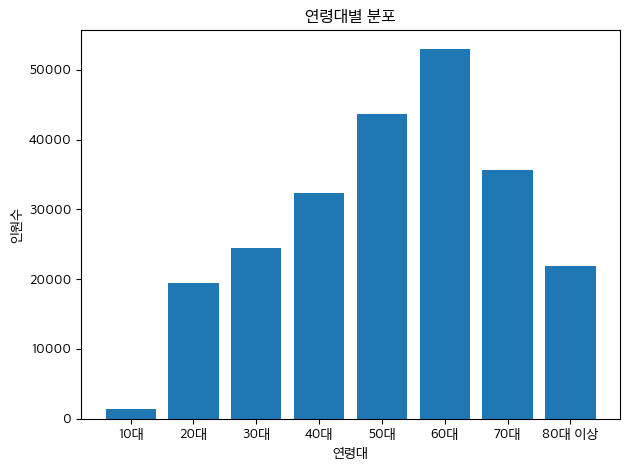

In [69]:
plt.bar(ag_count.index, ag_count.values)
plt.xlabel('연령대')
plt.ylabel('인원수')
plt.title('연령대별 분포')
plt.tight_layout()
plt.show()

In [70]:
#PHQ9 위험군 구분
bins  = [0, 5, 10, 15, 20, 28]
labels = ['정상범위','경과관찰','치료고려','치료요함','적극적치료']

phq9 = encode['phq']
encode['phq_group'] = pd.cut(phq9, bins=bins, labels=labels, right=True)

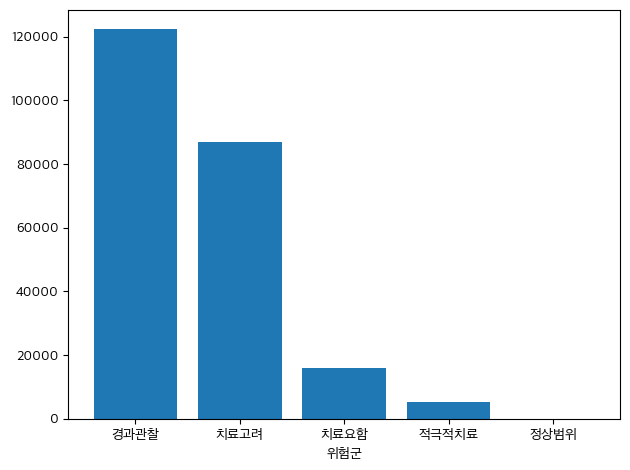

In [71]:
phq_count = encode['phq_group'].value_counts()
plt.bar(phq_count.index, phq_count.values)
plt.xlabel('위험군')
plt.tight_layout()
plt.show()

In [72]:
numeric_df = encode.select_dtypes(include='number')
numeric_cols = numeric_df.columns.tolist()

In [73]:
corr = numeric_df.corr()
corr

,age,sex,phq,sleep_mean,sleep_diff,ph_hard,ph_medium,ph_walk,ph_flex,stress,despair
age,1.000000,0.056548,0.084140,-0.184657,-0.364211,-0.095380,0.002524,-0.061381,-0.186548,0.201328,-0.024976
sex,0.056548,1.000000,0.109894,-0.055810,-0.043889,-0.112453,-0.069638,-0.078306,-0.186630,-0.033474,-0.063908
phq,0.084140,0.109894,1.000000,-0.161767,0.016487,-0.021624,-0.033876,-0.050081,-0.091790,-0.388487,-0.407033
sleep_mean,-0.184657,-0.055810,-0.161767,1.000000,0.272732,-0.000103,-0.016019,-0.017313,0.022664,0.076444,0.062448
sleep_diff,-0.364211,-0.043889,0.016487,0.272732,1.000000,0.042396,-0.011852,0.034031,0.072516,-0.117534,0.006946
ph_hard,-0.095380,-0.112453,-0.021624,-0.000103,0.042396,1.000000,0.222673,0.127682,0.122986,-0.024140,0.002051
ph_medium,0.002524,-0.069638,-0.033876,-0.016019,-0.011852,0.222673,1.000000,0.121634,0.041152,0.000606,0.017541
ph_walk,-0.061381,-0.078306,-0.050081,-0.017313,0.034031,0.127682,0.121634,1.000000,0.083947,0.007315,0.015023
ph_flex,-0.186548,-0.186630,-0.091790,0.022664,0.072516,0.122986,0.041152,0.083947,1.000000,0.018436,0.029974
stress,0.201328,-0.033474,-0.388487,0.076444,-0.117534,-0.024140,0.000606,0.007315,0.018436,1.000000,0.242772


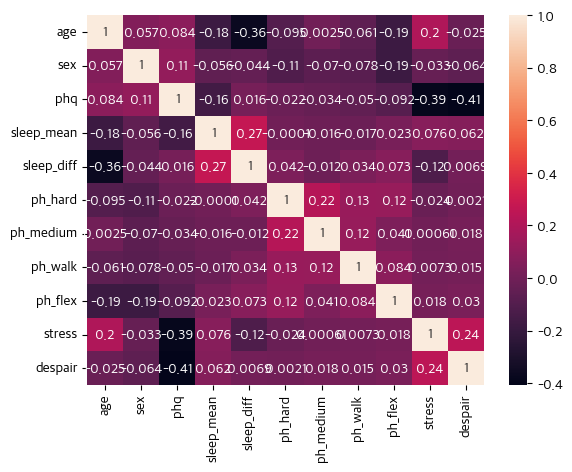

In [74]:
sns.heatmap(corr, annot=True)
plt.show()

#수면편차 0.02 
#신체활동 -0.2,-0.3,-0.5 : 비선형관계?
#스트레스 0.39
#절망감 #0.41

#비선형 모델 고려

In [75]:
group_corr = encode.groupby('phq_group', observed=True)[numeric_cols].apply(lambda g: g.corr().loc['phq']) 

<Axes: xlabel='phq', ylabel='phq_group'>

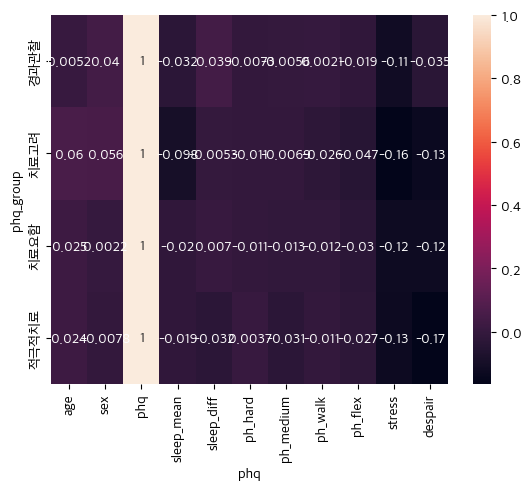

In [76]:
sns.heatmap(group_corr, annot=True)